In [4]:
!pip install opendatasets -q

# Import

In [2]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

<ipython-input-2-4d64df52c937>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [5]:
import pandas as pd
import numpy as np
import opendatasets as od

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Data Loading

In [6]:
od.download("https://www.kaggle.com/datasets/ryanholbrook/dl-course-data")

Dataset URL: https://www.kaggle.com/datasets/ryanholbrook/dl-course-data


100%|██████████| 231M/231M [00:03<00:00, 73.4MB/s]


In [8]:
hotel = pd.read_csv("/content/dl-course-data/hotel.csv")

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
  X['arrival_date_month'].map(
      {'January': 1, 'February': 2, 'March': 3,
       'April': 4, 'May': 5, 'June': 6, 'July': 7,
       'August': 8, 'September': 9, 'October': 10,
       'November': 11, 'December': 12}
  )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy='constant'), # There are a few missing value
    StandardScaler()
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat)
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
  train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print("Input Shape: ", input_shape)

Input Shape:  [63]


# 1) Define Model

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# 2) Add Optimizer, Loss, and Metric

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

Epoch 1/200
175/175 [==============================] - 8s 19ms/step - loss: 0.4813 - binary_accuracy: 0.7725 - val_loss: 0.4361 - val_binary_accuracy: 0.7948
Epoch 2/200
175/175 [==============================] - 4s 22ms/step - loss: 0.4231 - binary_accuracy: 0.7997 - val_loss: 0.4040 - val_binary_accuracy: 0.8148
Epoch 3/200
175/175 [==============================] - 7s 39ms/step - loss: 0.4080 - binary_accuracy: 0.8081 - val_loss: 0.3941 - val_binary_accuracy: 0.8154
Epoch 4/200
175/175 [==============================] - 4s 21ms/step - loss: 0.4014 - binary_accuracy: 0.8114 - val_loss: 0.3903 - val_binary_accuracy: 0.8207
Epoch 5/200
175/175 [==============================] - 3s 17ms/step - loss: 0.3959 - binary_accuracy: 0.8148 - val_loss: 0.3889 - val_binary_accuracy: 0.8211
Epoch 6/200
175/175 [==============================] - 3s 17ms/step - loss: 0.3920 - binary_accuracy: 0.8162 - val_loss: 0.3838 - val_binary_accuracy: 0.8217
Epoch 7/200
175/175 [==============================]

<Axes: title={'center': 'Accuracy'}>

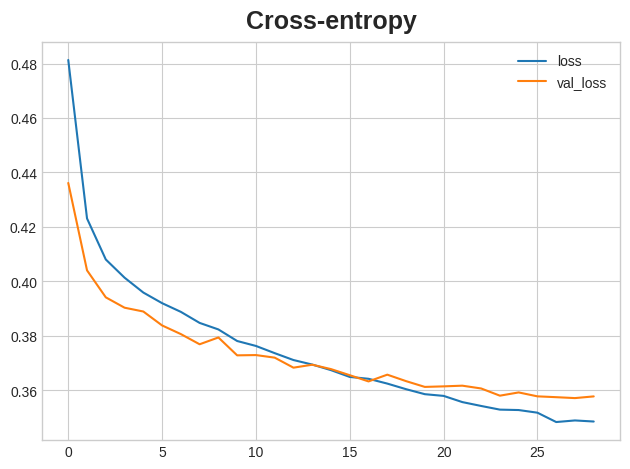

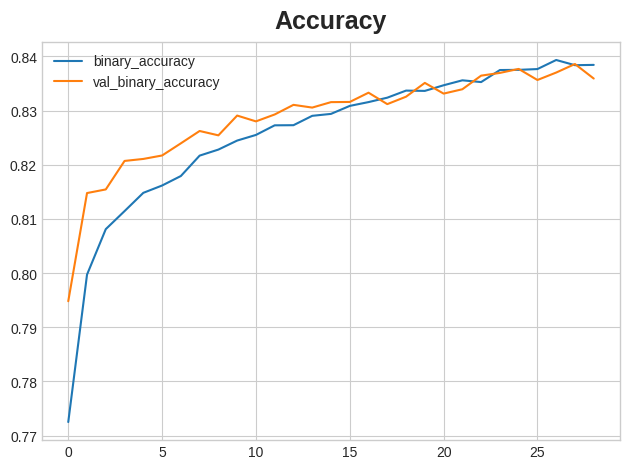

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")